# Dataset Statistics

# Annotation density distribution per detection head resolution

Saving to: c:\Users\alexh\Desktop\cv4\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json
total anns in df: 889455
from 60x60 hist  : 889455
from 120x120 hist: 889455
from 180x180 hist: 889455


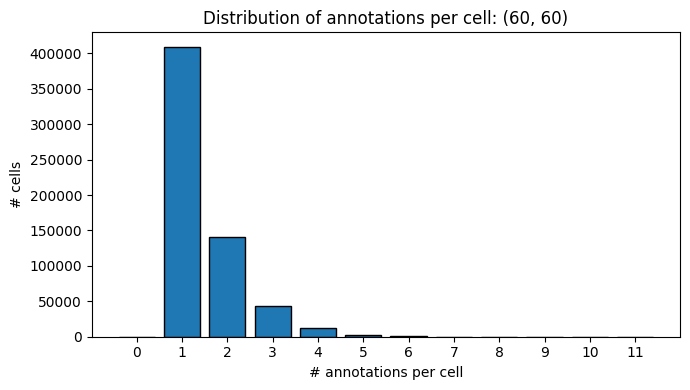

cells: 608841 | zero-cells: 0 (0.0%) | mean/cell: 1.4608986582703858


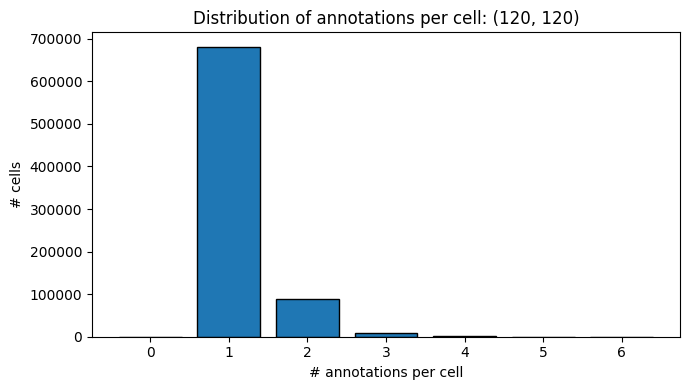

cells: 779405 | zero-cells: 0 (0.0%) | mean/cell: 1.1411974519024128


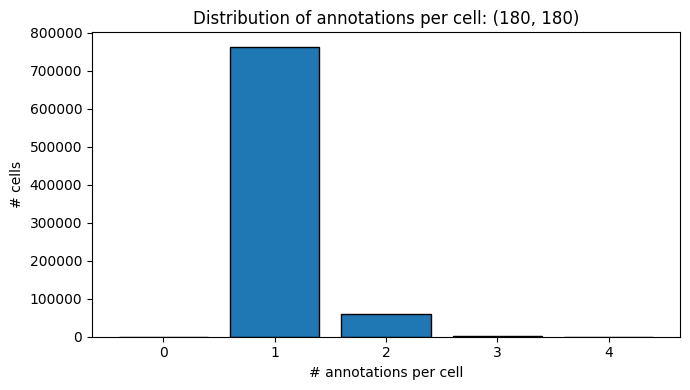

cells: 825712 | zero-cells: 0 (0.0%) | mean/cell: 1.0771976185401204


In [1]:
import pandas as pd
import util, eval
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def extractAnnotations(data):
    df = pd.DataFrame(data["annotations"]).transpose()
    width  = df["a_bbox"].str[2] - df["a_bbox"].str[0]
    height = df["a_bbox"].str[3] - df["a_bbox"].str[1]
    anns = df[(width!=0)&(height!=0)].copy()
    anns["cat_id"] = anns["cat_id"].str[0]
    anns["img_id"]  = pd.to_numeric(anns["img_id"])
    return anns.drop(columns=["o_bbox","area","comments"])

de = util.DataExtractor()
data = de.loadData()
img_df = pd.DataFrame(data["images"]).set_index("id")
anns = extractAnnotations(data)
gt_df = de.croppedData()


def per_cell_count_hist(grid=(112,112), include_all_images=True, exclude_zeros=True):
    gx, gy = grid
    hist = Counter()
    img_ids = (img_df.index if include_all_images else
               anns["img_id"].unique())

    for img_id in img_ids:
        w = img_df.at[img_id, "width"]; h = img_df.at[img_id, "height"]
        sub = anns[anns["img_id"] == img_id]

        if len(sub):
            a = np.stack(sub["a_bbox"].values)  # (N,4)
            xc = (a[:,0] + a[:,2]) * 0.5
            yc = (a[:,1] + a[:,3]) * 0.5
            i = np.clip((xc / w * gx).astype(int), 0, gx-1)
            j = np.clip((yc / h * gy).astype(int), 0, gy-1)
            k = j * gx + i
            counts = np.bincount(k, minlength=gx*gy)
        else:
            counts = np.zeros(gx*gy, dtype=int)

        if exclude_zeros:
            counts = counts[counts > 0]

        hist.update(counts.tolist())
    

    return hist

# build and plot
hist = per_cell_count_hist(grid=(240,240), include_all_images=False)
hist = per_cell_count_hist(grid=(60,60), include_all_images=False)

def total_from_hist(hist):  # works with or without zeros
    return sum(k * v for k, v in hist.items())

h60  = per_cell_count_hist(grid=(60,60),  include_all_images=True,  exclude_zeros=True)
h120 = per_cell_count_hist(grid=(120,120), include_all_images=True,  exclude_zeros=True)
h180 = per_cell_count_hist(grid=(180 ,180), include_all_images=True,  exclude_zeros=True)
print("total anns in df:", len(anns))
print("from 60x60 hist  :", total_from_hist(h60))
print("from 120x120 hist:", total_from_hist(h120))
print("from 180x180 hist:", total_from_hist(h180))

histograms = [(h60, (60, 60)), (h120, (120, 120)), (h180, (180, 180))]
for (hist, grid) in histograms:

    xs = np.arange(max(hist) + 1)
    ys = np.array([hist.get(x, 0) for x in xs])

    plt.figure(figsize=(7,4))
    plt.bar(xs, ys, edgecolor='black')
    plt.title(f"Distribution of annotations per cell: {grid}")
    plt.xlabel("# annotations per cell")
    plt.ylabel("# cells")
    plt.xticks(xs if len(xs) <= 50 else np.arange(0, xs[-1]+1, max(1, xs[-1]//20)))
    plt.tight_layout(); plt.show()

    # quick sanity stats
    total_cells = ys.sum()
    print("cells:", total_cells,
        "| zero-cells:", hist.get(0,0),
        f"({hist.get(0,0)/total_cells:.1%})",
        "| mean/cell:", np.average(xs, weights=ys))

# Number of images containing a class vs. total class occurence

number of images: 1362
number of annotations: 875337
avg number of annotations per image: 642.6850220264317
number of classes: 114


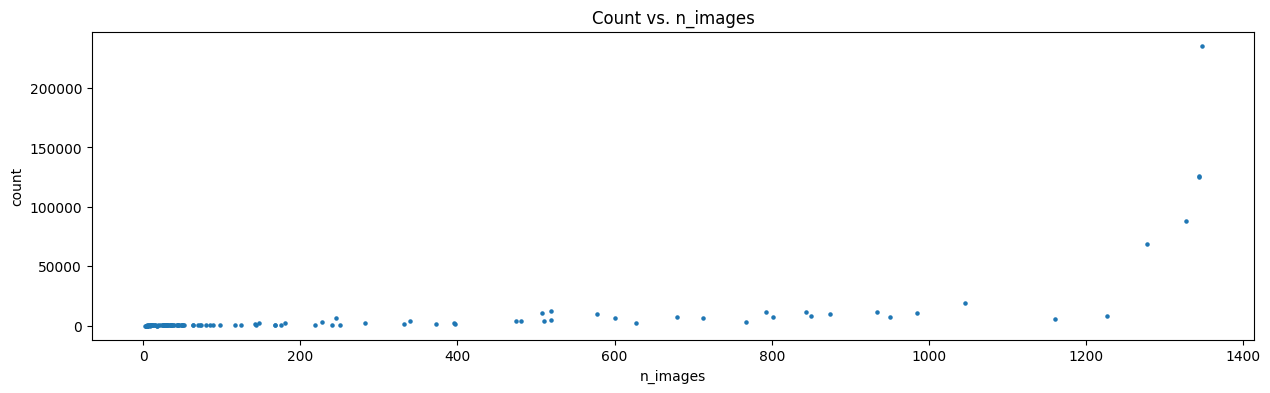

In [2]:
classes = eval.classReport(gt_df)

# Per-class mAP and mREC

In [3]:
classes.head(20)

,class_id,count,name,n_images,%_images,epoch,mAP,mREC
0,41,235695,stem,1347,98.898678,100,0.057569,0.047023
1,24,125497,noteheadBlackOnLine,1344,98.678414,100,0.442213,0.308992
2,26,125410,noteheadBlackInSpace,1344,98.678414,100,0.521332,0.369398
3,1,88316,ledgerLine,1327,97.430250,100,0.076485,0.062510
4,121,69016,beam,1277,93.759178,100,0.258973,0.252675
5,40,18723,augmentationDot,1046,76.798825,100,0.094079,0.077131
6,69,12685,keySharp,519,38.105727,100,0.556145,0.498021
7,30,11297,noteheadHalfInSpace,934,68.575624,100,0.351981,0.256367
8,84,11239,restWhole,793,58.223201,100,0.437755,0.457844
9,122,11034,tie,844,61.967695,100,0.158643,0.265568
